# Setup

In [1]:
!pip install datasets
from datasets import Dataset, DatasetDict

import json
import random
import re, os
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import transformers
import unicodedata
import numpy as np
from collections import defaultdict
from tqdm import notebook as tqdm
from sklearn.model_selection import train_test_split

np.random.seed(42)
random.seed(42)

try:
    assert torch.cuda.is_available()
    device = torch.device("cuda")
except:
    device = torch.device("cpu")
print("Using device:", device)

from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)
!pip install unidecode
from unidecode import unidecode
import unicodedata
import re
import html

def normalize_text(text):
    text = html.unescape(text)
    text = unicodedata.normalize('NFKD', text)
    text = unidecode(text)
    text = re.sub(r"\s+", " ", text)
    return text

Using device: cuda
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 4.3 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

folder = f"/content/drive/MyDrive/DH"
QP_FOLDER = f"{folder}/Early-Modern-Sermons/assets/QP_Datasets/TO-USE"

bible = {}

to_remove = {}
items = pd.read_csv(f"{folder}/Early-Modern-Sermons/assets/QP_Datasets/overly_vague.csv").to_dict(orient='records')
for entry in items:
  if " - " not in entry['verse_id']: continue
  to_remove[entry['verse_id']] = None

b_versions = ['AKJV','ODRV','Geneva', 'Douay-Rheims', 'Tyndale', 'Wycliffe','Vulgate']
for bname in b_versions:
    data = pd.read_csv(f"{folder}/Bibles/{bname}.csv",header=None)
    data = data.to_dict(orient="records")
    for entry in tqdm.tqdm(data):
        key = entry[0]
        v_id = key.split(" (")[0]
        text = entry[6]
        if re.search("Douay-Rheims",key):
            if re.sub("Douay-Rheims","ODRV",key) in bible: continue
        if len(text.split(" ")) < 200:
            bible[key] = normalize_text(f"{v_id}: {text}")

        parts = re.split(r'(?<=[\.\?]) (?=[A-Z])|(?<=[\!\:\;])', text)
        parts = [re.sub(r'\s+', ' ', p).strip() for p in parts if len(p.strip(" ")) > 0]
        if (len(parts[0].split(" ")) <= 5 or len(parts[-1].split(" ")) <= 5 or re.search(r"\&\w+\;",parts[0])):
            for pidx, p in enumerate(parts): continue
        elif len(parts) > 1:
            for pidx, p in enumerate(parts):
              p_id = f"{key} - {pidx}"
              if p_id in to_remove: continue
              if len(p) == 0: continue
              if re.search(r"\&\w+\;",p) or len(p.split(" ")) <= 5: continue
              bible[p_id] = normalize_text(f"Part {pidx+1} of {v_id}: {p}")

bible_verses = list(bible.values())
bible_ids = list(bible.keys())
verse_to_id = {v:k for k,v in bible.items()}
bible_parts = {}
for key, text in bible.items():
  v_id = key.split(" - ")[0]
  if v_id not in bible_parts:
    bible_parts[v_id] = [v_id]
  if " - " not in key: continue
  bible_parts[v_id].append(key)

def get_parts(pos_id):
  parts = []
  if len(bible_parts[pos_id]) > 0:
      for part_id in bible_parts[pos_id]:
        parts.append(part_id)
  return parts

v_id_to_idx = {v_id:idx for idx, v_id in enumerate(bible_ids)}
bible_verses_no_prepend = [re.sub(r"^[\d\w\s]+\d+\.\d+\: |^Part \d+ of [\d\w\s]+\d+\.\d+\: ",'',v) for v in bible_verses]
len(bible_verses), len(bible_parts)

Mounted at /content/drive


  0%|          | 0/36702 [00:00<?, ?it/s]

  0%|          | 0/14736 [00:00<?, ?it/s]

  0%|          | 0/31090 [00:00<?, ?it/s]

  0%|          | 0/35811 [00:00<?, ?it/s]

  0%|          | 0/7954 [00:00<?, ?it/s]

  0%|          | 0/9622 [00:00<?, ?it/s]

  0%|          | 0/35809 [00:00<?, ?it/s]

(276167, 157009)

In [3]:
!pip install sentence_transformers
from sentence_transformers import SentenceTransformer, models
from sentence_transformers.util import semantic_search, pytorch_cos_sim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 31.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [4]:
model_checkpoint = "emanjavacas/MacBERTh"
model_name = "MacBERTh"

if model_name == 'MacBERTh':
  word_embedding_model = models.Transformer(model_checkpoint, max_seq_length=128)
  pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(), "mean")
  bi_encoder = SentenceTransformer(modules=[word_embedding_model, pooling_model])
else:
  bi_encoder = SentenceTransformer(model_checkpoint)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/227k [00:00<?, ?B/s]

# Proper Nouns

In [5]:
with open(f"{folder}/Bibles/proper_nouns.json",'r') as file:
    e_to_v = json.load(file)
e_to_v['idols'] = e_to_v['household gods']
e_to_v['ariel'] = ['1 Chronicles 11.22']
e_to_v['stone-squarers'] = ['1 Kings 5.18']
for noun, refs in e_to_v.items():
  e_to_v[noun] = list(set(refs))

In [6]:
list(e_to_v.items())[-3]

('idols',
 ['Judges 17.5',
  'Genesis 31.19',
  'Hosea 3.4',
  'Zechariah 10.2',
  'Judges 18.14',
  'Genesis 31.35',
  'Genesis 31.34',
  'Judges 18.17',
  'Judges 18.18',
  '2 Kings 23.24',
  'Judges 18.20'])

In [7]:
import itertools
from difflib import SequenceMatcher

def normalize(text):
    return re.sub(r'[^a-zA-Z\s]', '', text).lower().strip()

def similarity(s1, s2):
    return SequenceMatcher(None, s1, s2).ratio()

In [8]:
with open(f"{folder}/Bibles/PARALLEL_VERSES.json") as file:
  PV,_ = json.load(file)
PV = {key:[_ for _ in entry['pos'] if " - " not in _] for key, entry in PV.items()}
len(PV)

31175

In [9]:
def search(vectors1, vectors2, proper_noun, words, refs):
  refs_word = {}
  hits = semantic_search(vectors1,vectors2,query_chunk_size=1000,top_k=10)[0]
  # print(proper_noun)
  for hit in hits:
    v_key = hit['corpus_id']
    if hit['score'] < 0.9: break

    for v_id in refs[v_key]:
      if v_id not in refs_word:
        refs_word[v_id] = words[v_key].capitalize() # add the first hit per verse
  return refs_word

In [10]:
from collections import defaultdict
min_similarity=0.7
max_ngram = 3


def search_noun(proper_noun):
  output = defaultdict(set)

  words_refs = defaultdict(list)
  for ref in e_to_v[proper_noun]:
    v_ids = PV.get(ref,[])
    for v_id in v_ids:
      verse_text = bible_verses_no_prepend[v_id_to_idx[v_id]]

      proper_noun = normalize(proper_noun)
      words = normalize(verse_text).split()

      best_match = None
      best_score = 0
      for n in range(1, max_ngram + 1):
        for i in range(len(words) - n + 1):
          ngram = ' '.join(words[i:i+n])
          words_refs[ngram].append(v_id)

          score = similarity(proper_noun, ngram)
          if score > best_score:
            best_score = score
            best_match = ngram

      if best_score >= min_similarity:
        output[v_id].update({best_match.capitalize()})

  refs = list(words_refs.values())
  words = list(words_refs.keys())
  noun_vec = bi_encoder.encode([proper_noun], batch_size=1024, convert_to_tensor=True, show_progress_bar=False)
  vectors = bi_encoder.encode(words, batch_size=1024, convert_to_tensor=True, show_progress_bar=False)
  refs_word = search(noun_vec, vectors, proper_noun, words, refs)

  for ref, word in refs_word.items():
    output[ref].update({word.capitalize()})

  return output

In [11]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

def plot_normal(data, xlabel='Number of References'):
  mean = np.mean(data)
  std = np.std(data)

  x = np.linspace(min(data), max(data), 100)
  pdf = norm.pdf(x, mean, std)
  plt.plot(x, pdf)
  plt.title(f'{model_name}\nMean={mean:.2f}, Std={std:.2f}')
  plt.xlabel(xlabel)
  plt.ylabel('Probability Density')
  plt.show()

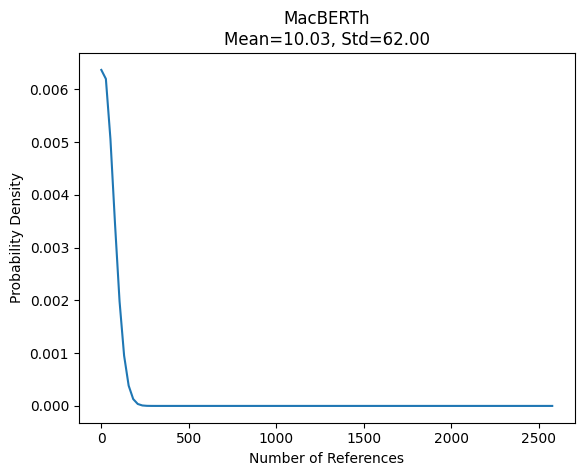

In [12]:
data = [len(v) for v in e_to_v.values()]
plot_normal(data)

In [13]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))
# https://wiki.digitalclassicist.org/Stopwords_for_Greek_and_Latin
stopwords.update({
    "ab", "ac", "ad", "adhic", "adhuc","aliqui", "aliquis", "an", "ante", "apud", "at",
    "atque", "aut", "autem", "cum", "cur", "de", "deinde", "dum", "ego", "enim",
    "ergo", "es", "est", "et", "etiam", "etsi", "ex", "fio", "haud", "hic", "iam",
    "idem", "igitur", "ille", "in", "infra", "inter", "interim", "ipse", "is", "ita",
    "magis", "modo", "mox", "nam", "ne", "nec", "necque", "neque", "nisi", "non", "nos",
    "o", "ob", "per", "possum", "post", "pro", "quae", "quam", "quare", "qui", "quia",
    "quicumque", "quidem", "quilibet", "quis", "quisnam", "quisquam", "quisque",
    "quisquis", "quo", "quoniam", "sed", "si", "sic", "sive", "sub", "sui", "sum",
    "super", "suus", "tam", "tamen", "trans", "tu", "tum", "ubi", "uel", "uero"
  }
)
print(stopwords)

{'super', 'inter', 'doing', 'quidem', 'off', 'our', "isn't", 'were', 'during', 'does', 'yourselves', 'can', 'nam', "mustn't", 'shan', 's', 'autem', 'now', 'those', 'it', 'adhic', 'which', 'against', 'y', 'idem', 'ma', "they'd", 'd', 'wasn', 'below', "she'd", 'themselves', 'own', 'myself', 'necque', 'trans', "won't", "it'll", 'because', 'too', 'modo', "doesn't", 't', 'quisquis', 'on', 'here', 'such', 'then', "we'll", 'why', 'ita', 'where', 'don', 'under', 'herself', 'once', 'while', 'just', 'aliqui', 'some', 'quisquam', 'me', 'ubi', 'de', 'as', 'sum', 'si', 'most', 'uero', 'and', 'hic', 'both', 'being', 'itself', "they've", "i'll", 'ex', 'tu', 'each', 'ourselves', 'having', "she's", 'pro', 'not', 'magis', 'suus', 'of', 'non', 'same', 'few', 'uel', 'so', 'theirs', 'was', 'his', "he's", 'for', 'out', "you've", 'sive', 'hadn', 'these', 'weren', 'll', 'but', 'more', "you're", 'had', 'est', "he'd", 'mightn', 'sub', 'their', "it's", 'yourself', 're', 'between', 'post', 'tum', 'when', 'ego', '

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [17]:
search_items = {noun:refs for noun, refs in e_to_v.items() if len(noun) >0 and len(refs) <= 10}
all_refs = set()
for refs in search_items.values():
  for ref in refs:
    if ref not in PV:
      continue
    all_refs.update(set(PV[ref]))
len(all_refs)

16589

In [22]:
all_proper_nouns = defaultdict(list)
# search_items = {'ariel':e_to_v['ariel'],'lionlike men':e_to_v['lionlike men']}

print((len(search_items)))
progress = tqdm.tqdm(search_items)
for noun in progress:
  progress.set_description(noun)
  output = search_noun(noun)
  for v_id, nouns in output.items():
    for np in nouns:
      for noun in np.split():
        if noun.lower() not in stopwords:
          all_proper_nouns[v_id].append(noun)

3250


  0%|          | 0/3250 [00:00<?, ?it/s]

In [23]:
all_v_ids_to_nouns = {}
for v_id in all_refs:
  nouns = all_proper_nouns.get(v_id, [])
  # nouns = list(nouns)
  # print(v_id, nouns)
  if len(nouns) == 0: continue
  all_v_ids_to_nouns[v_id] = nouns
  np = set(nouns)

  for word in bible_verses_no_prepend[v_id_to_idx[v_id]].split():
    if word.lower() in stopwords: continue
    if word[0].isupper() and word not in np:
      nouns.append(word.strip(";.,?:"))

  if len(nouns) > 1:
    all_v_ids_to_nouns[v_id] = nouns
  # print(v_id, all_v_ids_to_nouns[v_id])
'''
2 Samuel 23.20 (Geneva) ['Strong', 'men', 'Benaiah', 'Iehoiada', 'Kabzeel', 'Moab']
2 Kings 23.20 (Vulgate) ['Leones', 'moab', 'Banaias', 'Jojadae', 'Cabseel', 'Moab']
2 Kings 23.20 (Douay-Rheims) ['Valiant', 'man', 'Banaias', 'Joiada', 'Cabseel', 'Moab']
1 Chronicles 11.22 (AKJV) ['Kabzeel', 'Lyonlike', 'men', 'Benaiah', 'Iehoiada', 'Kabzeel', 'Lyon-like', 'Moab', 'Lyon']
1 Chronicles 11.22 (Geneva) ['Snowe', 'Strong', 'men', 'Benaiah', 'Iehoiada', 'Kabzeel', 'Moab']
2 Samuel 23.20 (AKJV) ['Lionlike', 'men', 'Benaiah', 'Iehoiada', 'Kabzeel', 'Moab', 'Lyon']
1 Paralipomenon 11.22 (Douay-Rheims) ['Ariels', 'Valiant', 'man', 'Banaias', 'Joiada', 'Cabseel', 'Moab']
1 Paralipomenon 11.22 (Vulgate) ['Ariel', 'Leonem', 'Banaias', 'Jojadae', 'Cabseel', 'Moab']
'''
len(all_v_ids_to_nouns)

14909

In [24]:
with open(f"{folder}/EEPS/PROPER_NOUN_TO_V_ID.json",'w+') as file:
  json.dump(all_v_ids_to_nouns,file)

In [ ]:
from google.colab import runtime
runtime.unassign()